# Running RBFE simulations with ATM 



## Introduction

This tutorial provides a step-by-step guide on how to run Alchemical Transfer Method (ATM) for a single ligand pair using HTMD libraries. By following this tutorial, you will learn how to set up the systems, prepare input files, execute ATM simulations and analyze the results. 

The tutorial also provides examples on how to perform ATM simulations with NNP/MM simulations, using AceForce to provide parameters for small molecules.


## Imports

In [ ]:
from htmd.ui import *
import yaml 
import os

## Preparing the system

The system we will use as an example is TYK2, one of the systems in the dataset from Wang et al. (https://pubs.acs.org/doi/abs/10.1021/ja512751q)
For this example, we'll pick one ligand pair from the whole dataset. We are going to compare ligand `ejm_31` and `jmc_28`. You can find them in the folder `./ATM_TYK2_example/`, along with a PDB file for TYK2. The ligands are already aligned in the binding site for this example.

In [2]:
# We'll start by loading the protein structure

mol = Molecule('ATM_TYK2_example/TYK2.pdb')

# autoSegment() function will automatically set the segIDs needed for building the system
mol = autoSegment(mol)


In [3]:
# Now, let's load the pair of ligands we want to compare in our ATM simulations

lig1 = Molecule('ATM_TYK2_example/parameters_ejm31/E31-orig.cif')
lig1.set("segid", "L1")
lig1_name = lig1.resname[0]

lig2 = Molecule('ATM_TYK2_example/parameters_jmc28/J28-orig.cif')
lig2.set("segid", "L2")
lig2_name = lig2.resname[0]


To perform ATM simulations, one of the ligands in the ligand pair is displaced outside of the binding site, on the solvent. As a general rule, we want to ensure the ligand will stay >15Å away from the protein. 

In [4]:
displacement_vec = [22.0, 22.0, 22.0]

mol.append(lig1)
mol.append(lig2)
mol.center()
mol.moveBy(displacement_vec, sel="segid L2")

# You can also visualize the system using the following command
# mol.view()

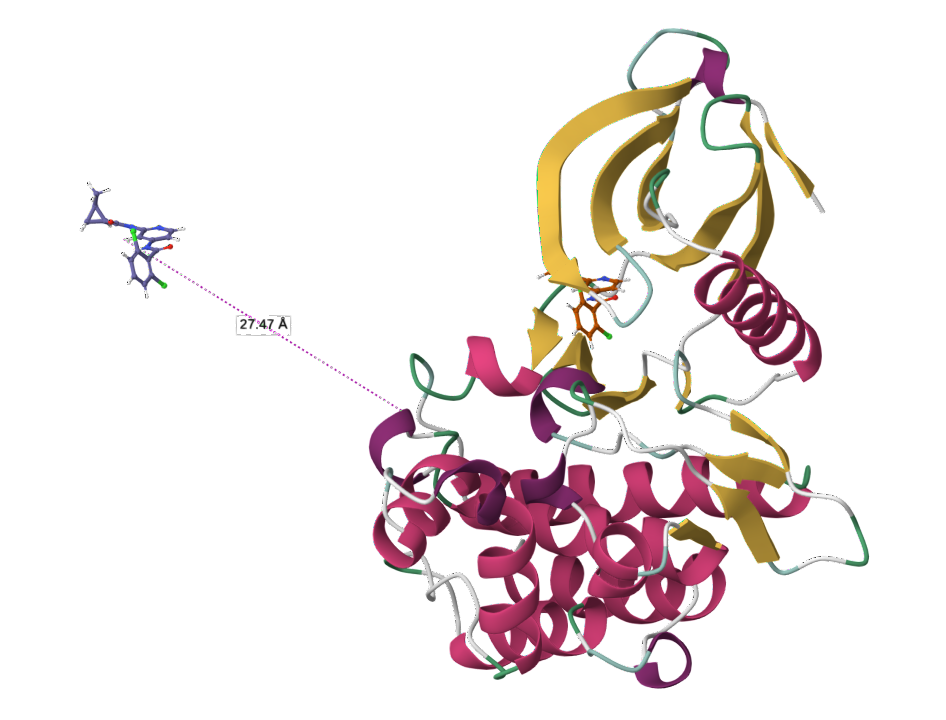

The image above shows an example of the system after the ligand displacement. As you can see, the ligand is >15Å away from the protein, ensuring that the RBFE estimation is valid.

Now, we can proceed to solvate the system in a water box and build parameters with Amber

In [5]:
smol = solvate(mol, pad=10)

2025-01-03 16:18:37,738 - htmd.builder.solvate - INFO - Using water pdb file at: /scratch/users/adria/software/mambaforge/envs/atm_env/lib/python3.10/site-packages/htmd/share/solvate/wat.pdb
2025-01-03 16:18:38,574 - htmd.builder.solvate - INFO - Replicating 8 water segments, 2 by 2 by 2
Solvating: 100%|██████████| 8/8 [00:04<00:00,  1.90it/s]
2025-01-03 16:18:43,840 - htmd.builder.solvate - INFO - 14542 water molecules were added to the system.


In [6]:
lig_topos = ['ATM_TYK2_example/parameters_ejm31/E31-orig.cif', 'ATM_TYK2_example/parameters_jmc28/J28-orig.cif']
lig_params = ['ATM_TYK2_example/parameters_ejm31/E31.frcmod', 'ATM_TYK2_example/parameters_jmc28/J28.frcmod']

topos_amber = amber.defaultTopo() + lig_topos
frcmods_amber = amber.defaultParam() + lig_params

bmol = amber.build(
    smol,
    topo=topos_amber,
    param=frcmods_amber,
    outdir='ATM_output/system_build/',
)

2025-01-03 16:18:47,559 - htmd.builder.amber - INFO - Detecting disulfide bonds.
2025-01-03 16:18:47,573 - htmd.builder.builder - INFO - 0 disulfide bonds were added
2025-01-03 16:18:50,008 - htmd.builder.amber - INFO - Starting the build.
2025-01-03 16:19:57,608 - htmd.builder.amber - INFO - Finished building.
2025-01-03 16:19:59,221 - moleculekit.writers - WARNING - Field "resid" of PDB overflows. Your data will be truncated to 4 characters.
2025-01-03 16:20:08,187 - htmd.builder.ionize - INFO - Adding 0 anions + 2 cations for neutralizing and 0 ions for the given salt concentration 0 M.
2025-01-03 16:20:11,931 - htmd.builder.amber - INFO - Starting the build.
2025-01-03 16:21:25,434 - htmd.builder.amber - INFO - Finished building.
2025-01-03 16:21:26,856 - moleculekit.writers - WARNING - Field "resid" of PDB overflows. Your data will be truncated to 4 characters.
/scratch/users/adria/software/mambaforge/envs/atm_env/lib/python3.10/site-packages/Bio/pairwise2.py:278: BiopythonDepreca

## Selecting restraint atoms

During the RBFE calculations, restraints keep both ligands approximately aligned to avoid conformational changes that would affect the convergence of the RBFE prediction. These restraints are based on a ligand coordinate frame defined by three atoms on each ligand.

There's some guidelines for the atom selection for restraints. Generally, all three atoms should be around the shared rigid-core of the molecules, and non-colinear. If the atoms selected for the reference molecule are not shared along the other molecules in the set, the automatic restraint atom assignment might fail. There's more details for the atom selection in the AToM-OpenMM doucmentation here:

https://www.compmolbiophysbc.org/atom-openmm/atom-system-setup

We'll pick the atom indexes based on the criteria explained in the previous section. 

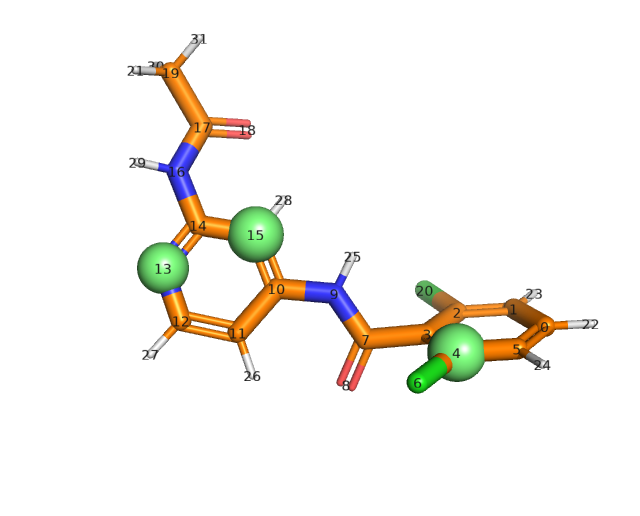

Which are the indexes `[13, 4, 15]`. These three atoms share the main criteria of being in the shared core between molecules, in rigid parts and non-colinear.

We'll now set the input file for ATM with the necessary atom indexes for restraints. The tutorial files provide a template configuration file with the default configuration parameters to run ATM, and we just need to fill in the blanks with the necessary atom indexes.

There are three types of restraints available to use during ATM simulations: the previously mentioned ligand alignment restraints, receptor positional restraints, and binding site restraints. In our experience, only the first two are needed, so binding site restraints are deactivated in our default configuration parameters. In case you want to use binding site restraints, just set the parameter `CM_KF=25.00` .

In [7]:
# Let's load a template input file for the ATM simulations, and fill up the necessary fields
with open('ATM_TYK2_example/templates/inputs.yaml', 'r') as f:
    config_params = yaml.safe_load(f)

In [8]:
# We'll set up a name for the simulation, used for naming input files
basename = 'TYK2_ejm31_jmc28'

config_params['BASENAME'] = basename

In [9]:
# We can now use the bmol object to fill up the necessary fields in the input file

lig1_restr_idx = [13, 4, 15]
lig2_restr_idx = [13, 4, 15] 

# First, we'll start by adding the displacement vector we used for the ligands
config_params["DISPLACEMENT"] = displacement_vec

# Next, we provide both ligand's atom indexes from the built system
lig1_atoms = bmol.get("index", sel=f"resname {lig1_name}")
lig2_atoms = bmol.get("index", sel=f"resname {lig2_name}")

config_params["LIGAND1_ATOMS"] = lig1_atoms.tolist()
config_params["LIGAND2_ATOMS"] = lig2_atoms.tolist()

# Continuing now with the restraints, we'll start with the ligand alignment restraints.
# Here we'll need to provide the original ligand atom indexes instead, the sum is then made internally with LIGAND1_ATOMS
config_params["ALIGN_LIGAND1_REF_ATOMS"] = lig1_restr_idx
config_params["ALIGN_LIGAND2_REF_ATOMS"] = lig2_restr_idx

# For the positional restraints, we can just provide indexes for the protein's carbon alpha atoms
config_params["POS_RESTRAINED_ATOMS"] = bmol.get("index", sel="name CA").tolist()

# The following parameters are just required in case you want to use the binding site restraints. Otherwise they will be ignored.
# We provide some reference atom for the ligands as a center, as well as all the carbon alpha atoms of residues near the binding site
config_params["LIGAND1_CM_ATOMS"] = [int(lig1_restr_idx[0] + lig1_atoms[0])]
config_params["LIGAND2_CM_ATOMS"] = [int(lig2_restr_idx[0] + lig2_atoms[0])]

resid_restr = np.unique(
    bmol.get("resid", f"within 4 of resname {lig1_name}")
).tolist()
config_params["RCPT_CM_ATOMS"] = bmol.get(
    "index", sel="name CA and resid " + " ".join(map(str, resid_restr))
).tolist()

## System equilibration

Once we have our built system and parameters, we can start with the simulation preparation. Before running production simulations, we need to do several steps to equilibrate and accomodate the system for RBFE simulations.

The equilibration protocol we are going to follow includes some initial minimization and thermalization steps, continued by some lambda annealing steps and finalizing with some equilibration steps at lambda 1/2.

In [10]:
from atm.rbfe_structprep import rbfe_structprep

In [11]:
# For the testing purpose of this tutorial, we are going to reduce the number of equilibration steps. 
# To run the standard equilibration, just comment the following lines

config_params['EQUIL_MINIM_STEPS'] = 10000
config_params['EQUIL_ANNEALING_STEPS'] = 10000
config_params['EQUIL_STEPS'] = 10000

In [12]:
# First, we prepare the necessary files for the equilibration run

build_dir = "ATM_output/system_build"
sim_dir = "ATM_output/atm_simulation_out"
os.makedirs(sim_dir, exist_ok=True)

shutil.copy(
    os.path.join(build_dir, "structure.prmtop"),
    os.path.join(sim_dir, f"{basename}.prmtop"),
)
shutil.copy(
    os.path.join(build_dir, "structure.crd"),
    os.path.join(sim_dir, f"{basename}.inpcrd"),
)

# We'll also need to create the yaml configuration file that containts all the settings for the run
sim_config = os.path.join(sim_dir, f"{basename}_config.yaml")
with open(sim_config, "w") as f:
    yaml.dump(config_params, f, default_flow_style=None)

In [13]:
# Let's run the equilibration!

rbfe_structprep(sim_config)

# We can also create a run.sh script to run the equilibration with a queue system later
# with open(os.path.join(equil_dir, 'run.sh'), "w+") as f:
#     f.write(f"#!/bin/bash\nrbfe_structprep.py {basename}_config.yaml >log.txt 2>&1


AToM RBFE Structure Preparation         

Started at: Fri Jan  3 16:21:44 2025
Input file: ATM_output/atm_simulation_out/TYK2_ejm31_jmc28_config.yaml



2025-01-03 16:21:47,236 - atm.rbfe_structprep - INFO - Integrator: LangevinMiddle
2025-01-03 16:21:47,237 - atm.rbfe_structprep - INFO - Temperature: 300.0 K
2025-01-03 16:21:47,238 - atm.rbfe_structprep - INFO - Friction: 0.1 /ps
2025-01-03 16:21:47,239 - atm.rbfe_structprep - INFO - Step size: 0.001 ps
2025-01-03 16:21:47,240 - atm.rbfe_structprep - INFO - Constraint toleratnce: 1e-05


Using platform CUDA
Potential energy before minimization = -560100.595711065 kJ/mol
Energy minimizing the system ...
Potential energy after minimization = -756090.940785089 kJ/mol
Thermalization ...
#"Step","Potential Energy (kJ/mole)","Temperature (K)","Box Volume (nm^3)"
5000,-755785.4855345748,30.692048509042785,589.584090935249
10000,-734697.6392950923,91.95512239578878,589.584090935249
NPT equilibration ...
15000,-698490.594919676,170.9267342352855,603.7101326147175
20000,-673524.2385274605,214.54030964290573,602.1429362301179
NVT equilibration ...
25000,-653925.4226071667,237.64132503771566,602.1429362301179
30000,-640109.8995451704,257.8451332701597,602.1429362301179


2025-01-03 16:23:18,664 - atm.rbfe_structprep - INFO - Integrator: LangevinMiddle
2025-01-03 16:23:18,666 - atm.rbfe_structprep - INFO - Temperature: 300.0 K
2025-01-03 16:23:18,667 - atm.rbfe_structprep - INFO - Friction: 0.1 /ps
2025-01-03 16:23:18,668 - atm.rbfe_structprep - INFO - Step size: 0.001 ps
2025-01-03 16:23:18,668 - atm.rbfe_structprep - INFO - Constraint toleratnce: 1e-05


Using platform CUDA
LoadState ...
Annealing to lambda = 1/2 ...
Potential Energy = -640109.8559659072 kJ/mol
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
35000,-629060.1720718341,267.67147662182657
40000,-623161.7159238637,280.65090367454553
SaveState ...


2025-01-03 16:23:51,967 - atm.rbfe_structprep - INFO - Integrator: LangevinMiddle
2025-01-03 16:23:51,970 - atm.rbfe_structprep - INFO - Temperature: 300.0 K
2025-01-03 16:23:51,971 - atm.rbfe_structprep - INFO - Friction: 0.1 /ps
2025-01-03 16:23:51,972 - atm.rbfe_structprep - INFO - Step size: 0.001 ps
2025-01-03 16:23:51,972 - atm.rbfe_structprep - INFO - Constraint toleratnce: 1e-05


Using platform CUDA
LoadState ...
Equilibration at lambda = 1/2 ...
Potential Energy = -1275032.6253352715 kJ/mol
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
45000,-618017.3848174014,284.0314320871569
50000,-614949.4281711259,289.7201499848688
SaveState ...


## ATM simulations

Once the equilibration is done, we can now start our ATM simulations. Process is straightforward, similar to the equilibration.

In case that you are interested in using NNPs to parameterize the ligands, the only thing you'll need is a checkpoint file for the NNP model. Our example shows how to load AceForce, but you can really provide any TorchMD-NET model there.

In [14]:
from atm.rbfe_production import rbfe_production

In [15]:
# For ATM production runs, we need to create a nodefile that specifies the visible GPU resources
with open(os.path.join(sim_dir, "nodefile"), "w+") as f:
    f.write("localhost,0:0,1,CUDA,,/tmp")

In [16]:
# In case that we want to run ATM simulations using NNP/MM simulations, these are the relevant configuration parameters

# config_params["NNP_MODEL"] = "TorchMD-NET"
# config_params["NNP_FILE"] = './aceforce_dft_1.0.0.ckpt'

# This last parameter depends on the number of atoms in your ligand.
# But be careful, as increasing this parameter greatly increases the computational cost!
# config_params["NNP_MAX_NUM_NEIGHBORS"] = 30


# Don't forget to update the configuration parameters after this!
# with open(sim_config, "w") as f:
#     yaml.dump(config_params, f, default_flow_style=None)

In [17]:
# For the testing purpose of this tutorial, we are going to reduce the number of production steps and maximum cycles
# To run the standard protocol, just comment the following lines

config_params['PRODUCTION_STEPS'] = 2000
config_params['MAX_SAMPLES'] = 2

with open(sim_config, "w") as f:
    yaml.dump(config_params, f, default_flow_style=None)

In [18]:
rbfe_production(sim_config)

# Again, we can create a run.sh script to run the production with a queue system later

# with open(os.path.join(prod_dir, 'run.sh'), "w+") as f:
#     f.write(f"#!/bin/bash\nrbfe_explicit_sync.py {basename}_config.yaml >log.txt 2>&1")


2025-01-03 16:34:50,413 - atm.rbfe_explicit_sync - INFO - Configuration:
2025-01-03 16:34:50,482 - atm.rbfe_explicit_sync - INFO - ACORE: 0.0625
2025-01-03 16:34:50,483 - atm.rbfe_explicit_sync - INFO - ALIGN_KF_SEP: 2.5
2025-01-03 16:34:50,484 - atm.rbfe_explicit_sync - INFO - ALIGN_K_PSI: 50.0
2025-01-03 16:34:50,485 - atm.rbfe_explicit_sync - INFO - ALIGN_K_THETA: 50.0
2025-01-03 16:34:50,486 - atm.rbfe_explicit_sync - INFO - ALIGN_LIGAND1_REF_ATOMS: [13, 4, 15]
2025-01-03 16:34:50,487 - atm.rbfe_explicit_sync - INFO - ALIGN_LIGAND2_REF_ATOMS: [13, 4, 15]
2025-01-03 16:34:50,488 - atm.rbfe_explicit_sync - INFO - ALPHA: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
2025-01-03 16:34:50,489 - atm.rbfe_explicit_sync - INFO - BASENAME: TYK2_ejm31_jmc28
2025-01-03 16:34:50,490 - atm.rbfe_explicit_sync - INFO - CHECKPOINT_FREQUENCY: 30
2025-01-03 16:34:50,491 - atm.rbfe_explicit_sync - INFO - CM_KF: 0.0
2025-01-03 16:34:50,49

## Analysis

Once the production is completed, we'll apply the UWHAM analysis method to obtain a relative binding free energy estimation out of the simulations.
We'll take the R script from [AToM-OpenMM](https://github.com/Gallicchio-Lab/AToM-OpenMM) repository to perform the analysis: `ATM_TYK2_example/templates/uwham_analysis.R`

In [ ]:
from atm.uwham import calculate_uwham

In [19]:
# These parameters allow you to select which samples you want to use for the analysis.
# It's recomneded to discard the first 30% samples.
rmin = np.amax([int(0.3 * int(config_params['MAX_SAMPLES'])), 1])

rmax = int(config_params["MAX_SAMPLES"])

# Now, we execute the analysis
ddG, ddG_std, _, _, samples = calculate_uwham(
    sim_dir, config_params["BASENAME"], rmin, rmax
)


CompletedProcess(args=['/scratch/users/adria/software/mambaforge/envs/atm_env/bin/R', 'CMD', 'BATCH', '-TYK2_ejm31_jmc28', '-1', '-2', 'uwham_analysis.R'], returncode=0)

In [20]:
print("ddG:", ddG)
print("Error", ddG_std)
print("Replicas", samples)

ddG: -1.536813
Error 3.094596
Replicas 2


*The prediction error is high because we used the reduced production steps for testing. Increasing simulation time to default values will reduce error and improve the prediction